In [1]:
######################################################
#
# ReaSCAN: on the mission for AGI with language.
#
# Author: Zhengxuan Wu (wuzhengx@stanford.edu)
#
# Descriptions:
# This script is used as initial plannings for the 
# ReaSCAN engine. It illustrate how to integrate different
# parts together, such as Mini-Grid gym etc..
#
# Notes:
# 1. We will leverage gSCAN core engines but with extensive 
# modifications for ReaSCAN. This ensures fairness of 
# comparisions.
######################################################

#### gym-minigrid
This part gets you familiar with minigrid gym env

In [2]:
from collections import namedtuple
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product

# from gym_minigrid.minigrid import MiniGridEnv
# from gym_minigrid.minigrid import Grid
# from gym_minigrid.minigrid import IDX_TO_OBJECT
# from gym_minigrid.minigrid import OBJECT_TO_IDX
# from gym_minigrid.minigrid import Circle
# from gym_minigrid.minigrid import Square
# from gym_minigrid.minigrid import Cylinder
# from gym_minigrid.minigrid import WorldObj
# from gym_minigrid.minigrid import Box
# from gym_minigrid.minigrid import DIR_TO_VEC
from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *

In [3]:
######################################################
# Move these to a new file probably

######################################################

In [4]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["quickly", "slowly", "while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box", "dax"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is", "which is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as", 
                    "same as", 
                    "inside of", 
                    "next to", 
                    "smaller than", 
                    "bigger than"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

In [5]:
# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

In [6]:
# test out situation repr
TEST_SITUATION_1 = Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
                             target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                            position=Position(row=10, column=4),
                                                            vector=np.array([1, 0, 1])),
                             placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                              position=Position(row=10, column=4),
                                                              vector=np.array([1, 0, 1])),
                                             PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                                              position=Position(row=3, column=12),
                                                              vector=np.array([0, 1, 0]))], carrying=None)
# TEST_SITUATION_1.to_representation()

In [7]:
# test out our new object definition
PositionedObject(object=Object(size=4, color='green', shape='box'),
                 position=Position(row=3, column=12),
                 vector=np.array([0, 1, 0]), overflow=True, overlap=True)

PositionedObject(object=Object(size=4, color='green', shape='box'), position=Position(column=12, row=3), vector=array([0, 1, 0]), overflow=True, overlap=True)

In [8]:
import numpy as np
from PyQt5.QtCore import Qt
from PyQt5.QtGui import QImage, QPixmap, QPainter, QColor, QPolygon
from PyQt5.QtCore import QPoint, QRect
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QTextEdit
from PyQt5.QtWidgets import QHBoxLayout, QVBoxLayout, QLabel, QFrame

class Window(QMainWindow):
    """
    Simple application window to render the environment into
    """

    def __init__(self):
        super().__init__()

        self.setWindowTitle('MiniGrid Gym Environment')

        # Image label to display the rendering
        self.imgLabel = QLabel()
        self.imgLabel.setFrameStyle(QFrame.Panel | QFrame.Sunken)

        # Text box for the mission
        self.missionBox = QTextEdit()
        self.missionBox.setReadOnly(True)
        self.missionBox.setMinimumSize(400, 100)

        # Center the image
        hbox = QHBoxLayout()
        hbox.addStretch(1)
        hbox.addWidget(self.imgLabel)
        hbox.addStretch(1)

        # Arrange widgets vertically
        vbox = QVBoxLayout()
        vbox.addLayout(hbox)
        vbox.addWidget(self.missionBox)

        # Create a main widget for the window
        self.mainWidget = QWidget(self)
        self.setCentralWidget(self.mainWidget)
        self.mainWidget.setLayout(vbox)

        # Show the application window
        self.show()
        self.setFocus()

        self.closed = False

        # Callback for keyboard events
        self.keyDownCb = None

    def closeEvent(self, event):
        self.closed = True

    def setPixmap(self, pixmap):
        self.imgLabel.setPixmap(pixmap)

    def setText(self, text):
        self.missionBox.setPlainText(text)

    def setKeyDownCb(self, callback):
        self.keyDownCb = callback

    def keyPressEvent(self, e):
        if self.keyDownCb == None:
            return

        keyName = None
        if e.key() == Qt.Key_Left:
            keyName = 'LEFT'
        elif e.key() == Qt.Key_Right:
            keyName = 'RIGHT'
        elif e.key() == Qt.Key_Up:
            keyName = 'UP'
        elif e.key() == Qt.Key_Down:
            keyName = 'DOWN'
        elif e.key() == Qt.Key_Space:
            keyName = 'SPACE'
        elif e.key() == Qt.Key_Return:
            keyName = 'RETURN'
        elif e.key() == Qt.Key_Alt:
            keyName = 'ALT'
        elif e.key() == Qt.Key_Control:
            keyName = 'CTRL'
        elif e.key() == Qt.Key_PageUp:
            keyName = 'PAGE_UP'
        elif e.key() == Qt.Key_PageDown:
            keyName = 'PAGE_DOWN'
        elif e.key() == Qt.Key_Backspace:
            keyName = 'BACKSPACE'
        elif e.key() == Qt.Key_Escape:
            keyName = 'ESCAPE'

        if keyName == None:
            return
        self.keyDownCb(keyName)


class Renderer:
    def __init__(self, width, height, ownWindow=False):
        self.width = width
        self.height = height

        self.img = QImage(width, height, QImage.Format_RGB888)
        self.painter = QPainter()

        self.window = None
        if ownWindow:
            self.app = QApplication([])
            self.window = Window()

    def close(self):
        """
        Deallocate resources used
        """
        pass

    def beginFrame(self):
        self.painter.begin(self.img)
        self.painter.setRenderHint(QPainter.Antialiasing, False)

        # Clear the background
        # comment this out for ReaSCAN purpose! little hacky i have to admit!
        # self.painter.setBrush(QColor(0, 0, 0))
        # self.painter.drawRect(0, 0, self.width - 1, self.height - 1)
        self.painter.fillRect(QRect(0, 0, self.width - 1, self.height - 1), QColor(0, 0, 0))
        
    def endFrame(self):
        self.painter.end()

        if self.window:
            if self.window.closed:
                self.window = None
            else:
                self.window.setPixmap(self.getPixmap())
                self.app.processEvents()

    def getPixmap(self):
        return QPixmap.fromImage(self.img)

    def save(self, save_location):
        self.app.processEvents()
        self.window.show()
        pix = QPixmap(self.window.mainWidget.size())
        self.window.mainWidget.render(pix)
        success = pix.save(save_location)
        return success

    def getArray(self):
        """
        Get a numpy array of RGB pixel values.
        The array will have shape (height, width, 3)
        """

        numBytes = self.width * self.height * 3
        buf = self.img.bits().asstring(numBytes)
        output = np.frombuffer(buf, dtype='uint8')
        output = output.reshape((self.height, self.width, 3))
        return output

    def getFullScreen(self, temp):
        pix = QPixmap(self.window.mainWidget.size())
        self.window.mainWidget.render(pix)
        image = pix.toImage()
        s = image.bits().asstring(image.width() * image.height() * 3)
        arr = np.fromstring(s, dtype='uint8').reshape((image.width(), image.height(), 3))
        pix.save(temp)
        return arr

    def push(self):
        self.painter.save()

    def pop(self):
        self.painter.restore()

    def rotate(self, degrees):
        self.painter.rotate(degrees)

    def translate(self, x, y):
        self.painter.translate(x, y)

    def scale(self, x, y):
        self.painter.scale(x, y)

    def setLineColor(self, r, g, b, a=255):
        self.painter.setPen(QColor(r, g, b, a))

    def setColor(self, r, g, b, a=255):
        self.painter.setBrush(QColor(r, g, b, a))

    def setLineWidth(self, width):
        pen = self.painter.pen()
        pen.setWidthF(width)
        self.painter.setPen(pen)

    def drawLine(self, x0, y0, x1, y1):
        self.painter.drawLine(x0, y0, x1, y1)

    def drawCircle(self, x, y, r):
        center = QPoint(x, y)
        self.painter.drawEllipse(center, r, r)

    def drawPolygon(self, points):
        """Takes a list of points (tuples) as input"""
        points = map(lambda p: QPoint(p[0], p[1]), points)
        self.painter.drawPolygon(QPolygon(points))

    def drawPolyline(self, points):
        """Takes a list of points (tuples) as input"""
        points = map(lambda p: QPoint(p[0], p[1]), points)
        self.painter.drawPolyline(QPolygon(points))

    def fillRect(self, x, y, width, height, r, g, b, a=255):
        self.painter.fillRect(QRect(x, y, width, height), QColor(r, g, b, a))
        
    def drawRect(self, x, y, width, height, line_width=5):
        # get current pen!
        pen = self.painter.pen()
        reset_widthF = pen.widthF()
        
        # draw the thicker box!
        pen.setWidthF(line_width)
        pen.setJoinStyle(Qt.MiterJoin)
        self.painter.setPen(pen)
        
        # draw the shape
#         points = [
#             (0, 60),
#             (60, 60),
#             (60, 0),
#             (0, 0)
#         ]
#         points = map(lambda p: QPoint(p[0], p[1]), points)
#         self.painter.drawPolygon(QPolygon(points))
        
        self.painter.drawRect(x, y, width, height)
        
        # reset back to avoid confusion for other shapes!
        pen = self.painter.pen()
        pen.setWidthF(reset_widthF)
        self.painter.setPen(pen)

In [17]:
import math
import gym
from enum import IntEnum
import numpy as np
from gym import spaces
from gym.utils import seeding

# Size in pixels of a cell in the full-scale human view
CELL_PIXELS = 60

# Map of color names to RGB values
COLORS = {
    'red': np.array([128, 0, 0]),
    'green': np.array([46, 139, 87]),
    'blue': np.array([25, 25, 112]),
    'purple': np.array([112, 39, 195]),
    'yellow': np.array([255, 191, 0]),
    'grey': np.array([100, 100, 100]),
    'pink': np.array([255, 192, 203])
}

COLOR_NAMES = sorted(list(COLORS.keys()))

# Used to map colors to integers
COLOR_TO_IDX = {
    'red': 0,
    'green': 1,
    'blue': 2,
    'purple': 3,
    'yellow': 4,
    'grey': 5,
    'pink': 6
}

IDX_TO_COLOR = dict(zip(COLOR_TO_IDX.values(), COLOR_TO_IDX.keys()))

# Map of object type to integers
OBJECT_TO_IDX = {
    'unseen': 0,
    'empty': 1,
    'circle': 2,
    'cylinder': 3,
    'square': 4,
    'box': 5,
    'dax': 6,
    'agent': 7,
}

IDX_TO_OBJECT = dict(zip(OBJECT_TO_IDX.values(), OBJECT_TO_IDX.keys()))

# Map of agent direction indices to vectors
DIR_TO_VEC = [
    # Pointing right (positive X)
    np.array((1, 0)),
    # Down (positive Y)
    np.array((0, 1)),
    # Pointing left (negative X)
    np.array((-1, 0)),
    # Up (negative Y)
    np.array((0, -1)),
]

# TODO: change
WEIGHT_TO_MOMENTUM = {
    "light": 1,
    "heavy": 2
}


class WorldObj:
    """
    Base class for grid world objects
    """

    def __init__(self, type, color, size=1, vector_representation=None, object_representation=None, target=False,
                 weight="light"):
        assert type in OBJECT_TO_IDX, type
        assert color in COLOR_TO_IDX, color
        assert 1 <= size <= 4, "Sizes outside of range [1,4] not supported."
        self.type = type
        self.color = color
        self.border_color = color
        self.contains = None
        self.size = size

        # Initial position of the object
        self.init_pos = None

        # Current position of the object
        self.cur_pos = None

        # Representations
        self.vector_representation = vector_representation
        self.object_representation = object_representation

        # Boolean whether an object is a target
        self.target = target

        # Determining whether a heavy object can be moved in the next step or not
        self.momentum = 0
        self.weight = weight
        self.momentum_threshold = WEIGHT_TO_MOMENTUM[self.weight]

    def can_overlap(self):
        """Can the agent overlap with this?"""
        return True

    def can_pickup(self):
        """Can the agent pick this up?"""
        return False

    def can_push(self):
        """Can the agent push this?"""
        return False

    def render(self, r):
        """Draw this object with the given renderer"""
        raise NotImplementedError

    def _set_color(self, r):
        """Set the color of this object as the active drawing color"""
        c = COLORS[self.color]
        border_color = COLORS[self.border_color]
        r.setLineColor(border_color[0], border_color[1], border_color[2])
        r.setColor(c[0], c[1], c[2])


class Square(WorldObj):
    def __init__(self, color='grey', size=1, vector_representation=None, object_representation=None, target=False,
                 weight="light"):
        super().__init__('square', color, size, vector_representation=vector_representation,
                         object_representation=object_representation, target=target, weight=weight)
        # TODO: generalize sizes
        self.drawing_offset_per_size = 2

    def render(self, r):
        self._set_color(r)

        # TODO: max_size is 4 here hardcoded
        if self.size == 4:
            width = (CELL_PIXELS * (self.size / 4)) - (self.drawing_offset_per_size * self.size)
        else:
            width = (CELL_PIXELS * (self.size / 4))
        r.drawPolygon([
            (0, width),
            (width, width),
            (width, 0),
            (0, 0)
        ])

    def can_pickup(self):
        return True

    def can_push(self):
        return True

    def can_object_overlap(self):
        return False
    
    def push(self):
        self.momentum += 1
        if self.momentum >= self.momentum_threshold:
            self.momentum = 0
            return True
        else:
            return False


class Cylinder(WorldObj):
    def __init__(self, color='blue', size=1, vector_representation=None, object_representation=None, weight="light"):
        super(Cylinder, self).__init__('cylinder', color, size, vector_representation,
                                       object_representation=object_representation, weight=weight)
        # TODO: generalize sizes
        self.drawing_offset_per_size = 2

    def can_pickup(self):
        return True

    def can_object_overlap(self):
        return False
    
    def render(self, r):
        self._set_color(r)

        # Vertical quad
        if self.size == 4:
            parallelogram_width = ((CELL_PIXELS / 2) * (self.size / 4)) - (self.drawing_offset_per_size * self.size)
            parallelogram_height = (CELL_PIXELS * (self.size / 4)) - (self.drawing_offset_per_size * self.size)
        else:
            parallelogram_width = ((CELL_PIXELS / 2) * (self.size / 4))
            parallelogram_height = (CELL_PIXELS * (self.size / 4))

        r.drawPolygon([
            (CELL_PIXELS / 2, 0),
            (CELL_PIXELS / 2 + parallelogram_width, 0),
            (CELL_PIXELS / 2, parallelogram_height),
            (CELL_PIXELS / 2 - parallelogram_width, parallelogram_height)
        ])

    def can_push(self):
        return True

    def push(self):
        self.momentum += 1
        if self.momentum >= self.momentum_threshold:
            self.momentum = 0
            return True
        else:
            return False


class Circle(WorldObj):
    def __init__(self, color='blue', size=1, vector_representation=None, object_representation=None, target=False,
                 weight="light"):
        super(Circle, self).__init__('circle', color, size, vector_representation,
                                     object_representation=object_representation, target=target, weight=weight)
        self.drawing_offset_per_size = 0.5
    def can_pickup(self):
        return True

    def can_push(self):
        return True

    def can_object_overlap(self):
        return False

    def render(self, r):
        self._set_color(r)
        if self.size == 4:
            radius = CELL_PIXELS // 10 * self.size - (self.drawing_offset_per_size * self.size)
        else:
            radius = CELL_PIXELS // 10 * self.size
        r.drawCircle(CELL_PIXELS * 0.5, CELL_PIXELS * 0.5, radius)

    def push(self):
        self.momentum += 1
        if self.momentum >= self.momentum_threshold:
            self.momentum = 0
            return True
        else:
            return False

        
class Box(WorldObj):
    """
    Box is not movable or pickable. Note that Box can be overflow and overlap!
    """
    def __init__(self, color='blue', size=1, vector_representation=None, object_representation=None, target=False,
                 weight="light", contains=None):
        super(Box, self).__init__('box', color, size, vector_representation,
                                  object_representation=object_representation, target=target, weight=weight)
        self.contains = contains
        self.border_color = color

    def can_pickup(self):
        return False

    def can_push(self):
        return False

    def can_object_overlap(self):
        return True
    
    def can_contain(self):
        """Can this contain another object?"""
        return False
    
    def _set_color(self, r):
        """
        This is special for box which is only to draw the border color.
        """
        # set border color only
        c = COLORS[self.color]
        border_color = COLORS[self.border_color]
        r.setLineColor(border_color[0], border_color[1], border_color[2])
    
    def render(self, r):
        self._set_color(r)
        r.drawRect(0,0,
                   CELL_PIXELS * self.size, 
                   CELL_PIXELS * self.size, line_width=8)

    def push(self):
        self.momentum += 1
        if self.momentum >= self.momentum_threshold:
            self.momentum = 0
            return True
        else:
            return False

        
class Dax(WorldObj):
    def __init__(self, color='blue', size=1, vector_representation=None, object_representation=None, target=False,
                 weight="light"):
        super(Dax, self).__init__('dax', color, size, vector_representation,
                                  object_representation=object_representation, target=target, weight=weight)

    def can_pickup(self):
        return True

    def can_push(self):
        return True

    def can_object_overlap(self):
        return False
    
    def render(self, r):
        self._set_color(r)
        raise NotImplementedError("Rendering for DAX is not implemented yet!")
        # r.drawCircle(CELL_PIXELS * 0.5, CELL_PIXELS * 0.5, CELL_PIXELS // 10 * self.size)

    def push(self):
        self.momentum += 1
        if self.momentum >= self.momentum_threshold:
            self.momentum = 0
            return True
        else:
            return False
        

class Grid:
    """
    Represent a grid and operations on it
    """

    def __init__(self, width, height, depth):
        assert width >= 3
        assert height >= 3

        self.width = width
        self.height = height
        self._num_attributes_object = depth
        self.grid = [None] * width * height

    def __contains__(self, key):
        if isinstance(key, WorldObj):
            for e in self.grid:
                if e is key:
                    return True
        elif isinstance(key, tuple):
            for e in self.grid:
                if e is None:
                    continue
                if (e.color, e.type) == key:
                    return True
                if key[0] is None and key[1] == e.type:
                    return True
        return False

    def __eq__(self, other):
        grid1 = self.encode()
        grid2 = other.encode()
        return np.array_equal(grid2, grid1)

    def __ne__(self, other):
        return not self == other

    def copy(self):
        from copy import deepcopy
        return deepcopy(self)

    def set(self, i, j, v, overlapping=False):
        assert i >= 0 and i < self.width
        assert j >= 0 and j < self.height
        if self.grid[j * self.width + i] == None:
            self.grid[j * self.width + i] = v
        else:
            old_v = self.grid[j * self.width + i]
            if overlapping or old_v.can_object_overlap():
                self.grid[j * self.width + i] = [old_v, v]

    def get(self, i, j):
        assert i >= 0 and i < self.width
        assert j >= 0 and j < self.height
        return self.grid[j * self.width + i]

    def rotate_left(self):
        """
        Rotate the grid to the left (counter-clockwise)
        """

        grid = Grid(self.height, self.width)

        for i in range(self.width):
            for j in range(self.height):
                v = self.get(i, j)
                grid.set(j, grid.height - 1 - i, v)

        return grid

    def slice(self, topX, topY, width, height):
        """
        Get a subset of the grid
        """

        grid = Grid(width, height)

        for j in range(0, height):
            for i in range(0, width):
                x = topX + i
                y = topY + j

                if x >= 0 and x < self.width and \
                   y >= 0 and y < self.height:
                    v = self.get(x, y)
                else:
                    v = Square()

                grid.set(i, j, v)

        return grid

    def render(self, r, tile_size, attention_weights=[]):
        """
        Render this grid at a given scale
        :param r: target renderer object
        :param tile_size: tile size in pixels
        """

        assert r.width == self.width * tile_size
        assert r.height == self.height * tile_size

        # Total grid size at native scale
        widthPx = self.width * CELL_PIXELS
        heightPx = self.height * CELL_PIXELS

        r.push()

        # Internally, we draw at the "large" full-grid resolution, but we
        # use the renderer to scale back to the desired size
        r.scale(tile_size / CELL_PIXELS, tile_size / CELL_PIXELS)

        if len(attention_weights) > 0:
            if len(attention_weights) == self.width * self.height:
                pixel_attention = False
                attention_weights = attention_weights.reshape(self.width, self.height)
            elif len(attention_weights) == self.width * CELL_PIXELS * self.height * CELL_PIXELS:
                pixel_attention = True
                attention_weights = attention_weights.reshape(self.width * CELL_PIXELS, self.height * CELL_PIXELS)
            start_range = 0
            end_range = 150
        else:
            pixel_attention = False
        # Draw the background of the in-world cells black
        if not pixel_attention:
            r.fillRect(
                0,
                0,
                widthPx,
                heightPx,
                255, 255, 255
            )
        else:
            for j in range(0, heightPx):
                for i in range(0, widthPx):
                    current_weight = attention_weights[j, i]
                    color = int((end_range - start_range) * (1 - current_weight))
                    r.push()
                    r.fillRect(i, j, 1, 1, r=color, g=color, b=color)
                    r.pop()

        # Draw grid lines
        r.setLineColor(100, 100, 100)
        for rowIdx in range(0, self.height):
            y = CELL_PIXELS * rowIdx
            r.drawLine(0, y, widthPx, y)
        for colIdx in range(0, self.width):
            x = CELL_PIXELS * colIdx
            r.drawLine(x, 0, x, heightPx)

        # Render the grid
        for j in range(0, self.height):
            for i in range(0, self.width):
                cell = self.get(i, j)
                if len(attention_weights) > 0 and not pixel_attention:
                    current_weight = attention_weights[j, i]
                    color = int((end_range - start_range) * (1 - current_weight))
                    r.push()
                    r.fillRect(i * CELL_PIXELS, j * CELL_PIXELS, CELL_PIXELS, CELL_PIXELS, r=color, g=color, b=color)
                if cell == None:
                    continue
                if isinstance(cell, list):
                    for sub_cell in cell:
                        r.push()
                        r.translate(i * CELL_PIXELS, j * CELL_PIXELS)
                        sub_cell.render(r)
                        r.pop()
                else:
                    r.push()
                    r.translate(i * CELL_PIXELS, j * CELL_PIXELS)
                    cell.render(r)
                    r.pop()

        r.pop()

    def encode(self, agent_row: int, agent_column: int, agent_direction: int):
        """
        Produce a compact numpy encoding of the grid.
        """
        array = np.zeros((self.width, self.height, self._num_attributes_object + 1 + 4), dtype='uint8')
        for col in range(self.width):
            for row in range(self.height):
                grid_cell = self.get(col, row)
                empty_representation = np.zeros(self._num_attributes_object + 1 + 4)
                if grid_cell:
                    empty_representation[:-5] = grid_cell.vector_representation

                # Set agent feature to 1 for the grid cell with the agent and add it's direction in one-hot form.
                if col == agent_column and row == agent_row:
                    empty_representation[-5] = 1
                    one_hot_direction = np.zeros(4)
                    one_hot_direction[agent_direction] = 1
                    empty_representation[-4:] = one_hot_direction
                array[row, col, :] = empty_representation
        return array


class MiniGridEnv(gym.Env):
    """
    2D grid world game environment.
    """

    metadata = {
        'render.modes': ['human', 'rgb_array', 'pixmap'],
        'video.frames_per_second': 10
    }

    # Enumeration of possible actions
    class Actions(IntEnum):
        # Turn left, turn right, move forward
        left = 0
        right = 1
        forward = 2

        # Pick up an object
        pickup = 3
        # Drop an object
        drop = 4

        # Done completing task
        done = 6

    def __init__(self, grid_size=None, width=None, height=None, max_steps=100, seed=42):
        # Can't set both grid_size and width/height
        if grid_size:
            assert width == None and height == None
            width = grid_size
            height = grid_size

        # Action enumeration for this environment
        self.actions = MiniGridEnv.Actions

        # Actions are discrete integer values
        self.action_space = spaces.Discrete(len(self.actions))

        # Range of possible rewards
        self.reward_range = (0, 1)

        # Renderer object used to render the whole grid (full-scale)
        self.grid_render = None

        # Renderer used to render observations (small-scale agent view)
        self.obs_render = None

        # Environment configuration
        self.width = width
        self.height = height
        self.max_steps = max_steps

        # Current position and direction of the agent
        self.agent_pos = None
        self.agent_dir = None

        # Initialize the RNG
        self.seed(seed=seed)

        # Initialize the state
        self.reset()

    def reset(self):
        # Current position and direction of the agent
        self.agent_pos = None
        self.agent_dir = None

        # Generate a new random grid at the start of each episode
        # To keep the same grid for each episode, call env.seed() with
        # the same seed before calling env.reset()
        self._gen_grid(self.width, self.height)

        # These fields should be defined by _gen_grid
        assert self.agent_pos is not None
        assert self.agent_dir is not None

        # Check that the agent doesn't overlap with an object
        start_cell = self.grid.get(*self.agent_pos)
        assert start_cell is None or start_cell.can_overlap()

        # Item picked up, being carried, initially nothing
        self.carrying = None

        # Step count since episode start
        self.step_count = 0

        return

    def seed(self, seed=1337):
        # Seed the random number generator
        self.np_random, _ = seeding.np_random(seed)
        return [seed]

    @property
    def steps_remaining(self):
        return self.max_steps - self.step_count

    def __str__(self):
        """
        Produce a pretty string of the environment's grid along with the agent.
        A grid cell is represented by 2-character string, the first one for
        the object and the second one for the color.
        """

        # Map of object types to short string
        OBJECT_TO_STR = {
            'circle': 'A',
            'square': 'B',
            'cylinder': 'C',
            'box': 'D',
            'dax': 'E',
        }

        # Map agent's direction to short string
        AGENT_DIR_TO_STR = {
            0: '>',
            1: 'V',
            2: '<',
            3: '^'
        }

        str = ''
        for j in range(self.grid.height):
            for i in range(self.grid.width):
                if i == self.agent_pos[0] and j == self.agent_pos[1]:
                    str += 2 * AGENT_DIR_TO_STR[self.agent_dir]
                    continue
                c = self.grid.get(i, j)
                if not c:
                    str += '  '
                    continue
                if len(c) > 1:
                    # very hacky way assuming ReaSCAN is not using this anyway!
                    for sub_c in c:
                        str += OBJECT_TO_STR[sub_c.type] + sub_c.color[0].upper()
                else:
                    str += OBJECT_TO_STR[c.type] + c.color[0].upper()
            if j < self.grid.height - 1:
                str += '\n'
        return str

    def _gen_grid(self, width, height):
        assert False, "_gen_grid needs to be implemented by each environment"

    def _rand_int(self, low, high):
        """
        Generate random integer in [low,high]
        """

        return self.np_random.randint(low, high)

    def place_obj(self, obj, top=None, size=None, reject_fn=None, max_tries=math.inf):
        """
        Place an object at an empty position in the grid

        :param obj:
        :param top: top-left position of the rectangle where to place
        :param size: size of the rectangle where to place
        :param reject_fn: function to filter out potential positions
        :param max_tries:
        """

        if top is None:
            top = (0, 0)
        else:
            top = (max(top[0], 0), max(top[1], 0))

        if size is None:
            size = (self.grid.width, self.grid.height)

        num_tries = 0

        while True:
            # This is to handle with rare cases where rejection sampling
            # gets stuck in an infinite loop
            if num_tries > max_tries:
                raise RecursionError('rejection sampling failed in place_obj')

            num_tries += 1

            pos = np.array((
                self._rand_int(top[0], min(top[0] + size[0], self.grid.width)),
                self._rand_int(top[1], min(top[1] + size[1], self.grid.height))
            ))

            # Don't place the object on top of another object
            if self.grid.get(*pos) != None and not obj.can_object_overlap():
                continue

            # Check if there is a filtering criterion
            if reject_fn and reject_fn(self, pos):
                continue

            break

        if not obj.can_object_overlap():
            self.grid.set(*pos, obj)
        else:
            self.grid.set(*pos, obj, overlapping=True)

        if obj is not None:
            obj.init_pos = pos
            obj.cur_pos = pos

        return pos

    def place_agent(
        self,
        top=None,
        size=None,
        rand_dir=True,
        max_tries=math.inf
    ):
        """
        Set the agent's starting point at an empty position in the grid
        """

        self.agent_pos = None
        pos = self.place_obj(None, top, size, max_tries=max_tries)
        self.agent_pos = pos

        if rand_dir:
            self.agent_dir = self._rand_int(0, 4)

        return pos

    @property
    def dir_vec(self):
        """
        Get the direction vector for the agent, pointing in the direction
        of forward movement.
        """

        assert self.agent_dir >= 0 and self.agent_dir < 4
        return DIR_TO_VEC[self.agent_dir]

    @property
    def right_vec(self):
        """
        Get the vector pointing to the right of the agent.
        """

        dx, dy = self.dir_vec
        return np.array((-dy, dx))

    @property
    def front_pos(self):
        """
        Get the position of the cell that is right in front of the agent
        """

        return self.agent_pos + self.dir_vec

    def step(self, action):
        self.step_count += 1

        reward = 0
        done = False

        current_cell = self.grid.get(*self.agent_pos)

        # Rotate left
        if action == self.actions.left:
            self.agent_dir -= 1
            if self.agent_dir < 0:
                self.agent_dir += 4

        # Rotate right
        elif action == self.actions.right:
            self.agent_dir = (self.agent_dir + 1) % 4

        # Move forward
        elif action == self.actions.forward:
            # Get the position in front of the agent
            fwd_pos = self.front_pos

            # Get the contents of the cell in front of the agent
            fwd_cell = self.grid.get(*fwd_pos)
            if fwd_cell == None or fwd_cell.can_overlap():
                self.agent_pos = fwd_pos
            if fwd_cell != None and fwd_cell.type == 'goal':
                done = True
                reward = self._reward()
            if fwd_cell != None and fwd_cell.type == 'lava':
                done = True

        # Pick up an object
        elif action == self.actions.pickup:
            if current_cell.can_pickup():
                if self.carrying is None:
                    self.carrying = current_cell
                    self.carrying.cur_pos = np.array([-1, -1])
                    self.grid.set(*self.agent_pos, None)

        # Drop an object
        elif action == self.actions.drop:
            if not current_cell and self.carrying:
                self.grid.set(*self.agent_pos, self.carrying)
                self.carrying.cur_pos = self.agent_pos
                self.carrying = None

        # Done action (not used by default)
        elif action == self.actions.done:
            pass

        else:
            assert False, "unknown action"

        if self.step_count >= self.max_steps:
            done = True

        return reward, done, {}

    def render(self, mode='', close=False, highlight=True, tile_size=CELL_PIXELS, attention_weights=[]):
        """
        Render the whole-grid human view
        """

        if close:
            if self.grid_render:
                self.grid_render.close()
            return

        if self.grid_render is None or self.grid_render.window is None or (self.grid_render.width != self.width * tile_size):
            # from gym_minigrid.rendering import Renderer
            self.grid_render = Renderer(
                self.width * tile_size,
                self.height * tile_size,
                True if mode == 'human' else False
            )

        r = self.grid_render

        if r.window:
            r.window.setText(self.mission)

        r.beginFrame()

        # Render the whole grid
        if len(attention_weights) > 0:
            flat_attention_weights = attention_weights[0]
        else:
            flat_attention_weights = attention_weights
        self.grid.render(r, tile_size, attention_weights=flat_attention_weights)

        # Draw the agent
        ratio = tile_size / CELL_PIXELS
        r.push()
        r.scale(ratio, ratio)
        r.translate(
            CELL_PIXELS * (self.agent_pos[0] + 0.5),
            CELL_PIXELS * (self.agent_pos[1] + 0.5)
        )
        r.rotate(self.agent_dir * 90)
        r.setLineColor(255, 192, 203)
        r.setColor(255, 192, 203)
        r.drawPolygon([
            (-12, 10),
            (12, 0),
            (-12, -10)
        ])
        r.pop()
        r.endFrame()

        if mode == 'rgb_array':
            return r.getArray()
        elif mode == 'pixmap':
            return r.getPixmap()
        return r

In [18]:
class World(MiniGridEnv):
    """
    Wrapper class to execute actions in a world state. Connected to minigrid.py in gym_minigrid for visualizations.
    Every time actions are executed, the commands and situations are saved in self._observed_commands and
    self._observed_situations, which can then be retrieved with get_current_observations().
    The world can be cleared with clear_situation().
    """

    AVAILABLE_SHAPES = {"circle", "square", "cylinder", "box", "dax"}
    AVAILABLE_COLORS = {"red", "blue", "green", "yellow"}

    def __init__(self, grid_size: int, shapes: List[str], colors: List[str], object_vocabulary: ObjectVocabulary,
                 save_directory: str):
        # Some checks on the input
        for shape, color in zip(shapes, colors):
            assert shape in self.AVAILABLE_SHAPES, "Specified shape {} not implemented in minigrid env.".format(shape)
            assert color in self.AVAILABLE_COLORS, "Specified color {}, not implemented in minigrid env.".format(color)

        # Define the grid world.
        self.grid_size = grid_size

        # Column, row
        self.agent_start_pos = (0, 0)
        self.agent_start_dir = DIR_TO_INT[EAST]
        self.mission = None

        # Generate the object vocabulary.
        self._object_vocabulary = object_vocabulary
        self.num_available_objects = len(IDX_TO_OBJECT.keys())
        self.available_objects = set(OBJECT_TO_IDX.keys())

        # Data structures for keeping track of the current state of the world.
        self._placed_object_list = []
        self._target_object = None
        self._observed_commands = []
        self._observed_situations = []
        self._occupied_positions = set()
        # Hash table for looking up locations of objects based on partially formed references (e.g. find the location(s)
        # of a red cylinder when the grid has both a big red cylinder and a small red cylinder.)
        self._object_lookup_table = {}
        self.save_directory = save_directory
        super().__init__(grid_size=grid_size, max_steps=4 * grid_size * grid_size)

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height, depth=self._object_vocabulary.num_object_attributes)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            position = self.place_agent()
            self._occupied_positions.add(position)

    def initialize(self, objects: List[Tuple[Object, Position]], agent_position: Position, agent_direction: Direction,
                   target_object: PositionedObject, carrying: Object=None):
        """
        Create a grid world by placing the objects that are passed as an argument at the specified locations and the
        agent at the specified location.
        """
        self.clear_situation()
        self.agent_dir = DIR_TO_INT[agent_direction]
        self.place_agent_at(agent_position)
        self._target_object = target_object
        for current_object, current_position in objects:
            target = False
            if target_object:
                if target_object.position == current_position:
                    target = True
            self.place_object(current_object, current_position, target=target)
        if carrying:
            carrying_object = self.create_object(carrying,
                                                 self._object_vocabulary.get_object_vector(carrying.shape,
                                                                                           carrying.color,
                                                                                           carrying.size))
            self.carrying = carrying_object
            self.carrying.cur_pos = np.array([-1, -1])
            self.carrying.cur_pos = self.agent_pos

    def create_object(self, object_spec: Object, object_vector: np.ndarray, target=False):
        if object_spec.shape == "circle":
            return Circle(object_spec.color, size=object_spec.size, vector_representation=object_vector,
                          object_representation=object_spec, target=target,
                          weight=self._object_vocabulary.object_in_class(object_spec.size))
        elif object_spec.shape == "square":
            return Square(object_spec.color, size=object_spec.size, vector_representation=object_vector,
                          object_representation=object_spec, target=target,
                          weight=self._object_vocabulary.object_in_class(object_spec.size))
        elif object_spec.shape == "cylinder":
            return Cylinder(object_spec.color, size=object_spec.size, vector_representation=object_vector,
                            object_representation=object_spec,
                            weight=self._object_vocabulary.object_in_class(object_spec.size))
        elif object_spec.shape == "box":
            return Box(object_spec.color, size=object_spec.size, vector_representation=object_vector,
                       object_representation=object_spec,
                       weight=self._object_vocabulary.object_in_class(object_spec.size))
        else:
            raise ValueError("Trying to create an object shape {} that is not implemented.".format(object_spec.shape))

    def position_taken(self, position: Position):
        return self.grid.get(position.column, position.row) is not None

    def within_grid(self, position: Position):
        if 0 <= position.row < self.grid_size and 0 <= position.column < self.grid_size:
            return True
        else:
            return False

    def place_agent_at(self, position: Position):
        if not self.position_taken(position):
            self.place_agent(top=(position.column, position.row), size=(1, 1), rand_dir=False)
            self._occupied_positions.add((position.column, position.row))
        else:
            raise ValueError("Trying to place agent on cell that is already taken.")

    def sample_position(self) -> Position:
        available_positions = [(row, col) for row, col in itertools.product(list(range(self.grid_size)),
                                                                            list(range(self.grid_size)))
                               if (col, row) not in self._occupied_positions]
        sampled_position = random.sample(available_positions, 1).pop()
        return Position(row=sampled_position[0], column=sampled_position[1])

    def min_distance_from_edge(self, position: Position):
        row_distance = min(self.grid_size - position.row, position.row)
        column_distance = min(self.grid_size - position.column, position.column)
        return min(row_distance, column_distance)

    def sample_position_steps_from_edge(self, distance_from_edge=1) -> Position:
        available_positions = [(row, col) for row, col in itertools.product(list(range(self.grid_size)),
                                                                            list(range(self.grid_size)))
                               if (row, col) not in self._occupied_positions]
        actual_available_positions = []
        for row, col in available_positions:
            if self.min_distance_from_edge(Position(row=row, column=col)) <= distance_from_edge:
                actual_available_positions.append((row, col))
        sampled_position = random.sample(actual_available_positions, 1).pop()
        return Position(row=sampled_position[0], column=sampled_position[1])

    def sample_position_conditioned(self, north, east, south, west):
        """
        Specify for each direction how many steps should be free (i.e. before hitting wall) in that direction.
        """
        assert north == 0 or south == 0, "Can't take steps in both North and South direction"
        assert east == 0 or west == 0, "Can't take steps in both East and West direction"

        max_col = self.grid_size - east if east > 0 else self.grid_size - 1
        min_col = west - 1 if west > 0 else 0
        max_row = self.grid_size - south if south > 0 else self.grid_size - 1
        min_row = north - 1 if north > 0 else 0
        available_positions = []
        for col in range(min_col, max_col + 1):
            for row in range(min_row, max_row + 1):
                available_positions.append((row, col))
        sampled_position = random.sample(available_positions, 1).pop()
        return Position(row=sampled_position[0], column=sampled_position[1])

    def place_object(self, object_spec: Object, position: Position, target=False):
        if not self.within_grid(position):
            raise IndexError("Trying to place object '{}' outside of grid of size {}.".format(
                object_spec.shape, self.grid_size))
        # Double box is not allowed here!
        if self.position_taken(position) and object_spec.shape == "box" and self._occupy_by_box(position):
            print("WARNING: attempt to place two boxes at location ({}, {}), but overlapping boxes not "
                  "supported. Skipping object.".format(position.row, position.column))
            return
        # Object already placed at this location
        if (self.position_taken(position) and object_spec.shape != "box" and not self._occupy_by_box(position)):
            print("WARNING: attempt to place two objects at location ({}, {}), but overlapping objects not "
                  "supported if it is for a box. Skipping object.".format(position.row, position.column))
            return

        object_vector = self._object_vocabulary.get_object_vector(shape=object_spec.shape, color=object_spec.color,
                                                                  size=object_spec.size)
        positioned_object = PositionedObject(object=object_spec, position=position, vector=object_vector)
        self.place_obj(self.create_object(object_spec, object_vector, target=target),
                       top=(position.column, position.row), size=(1, 1))

        # Add to list that keeps track of all objects currently positioned on the grid.
        self._placed_object_list.append(positioned_object)

        # Adjust the object lookup table accordingly.
        self._add_object_to_lookup_table(positioned_object)

        # Add to occupied positions:
        self._occupied_positions.add((position.column, position.row))

        if target:
            self._target_object = positioned_object

    def _occupy_by_box(self, query_position):
        if "box" in self._object_lookup_table.keys():
            for _, position in world._object_lookup_table["box"].items():
                for position in positions:
                    if position.column == query_position.column and position.row == query_position.row:
                        # this is a box!
                        return True
        return False
                
    def _add_object_to_lookup_table(self, positioned_object: PositionedObject):
        object_size = positioned_object.object.size
        object_color = positioned_object.object.color
        object_shape = positioned_object.object.shape

        # Generate all possible names
        object_names = generate_possible_object_names(color=object_color, shape=object_shape)
        for possible_object_name in object_names:
            if possible_object_name not in self._object_lookup_table.keys():
                self._object_lookup_table[possible_object_name] = {}

            # This part allows for multiple exactly the same objects (e.g. 2 small red circles) to be on the grid.
            if positioned_object.object.size not in self._object_lookup_table[possible_object_name].keys():
                self._object_lookup_table[possible_object_name] = {
                    size: [] for size in self._object_vocabulary.object_sizes}
            self._object_lookup_table[possible_object_name][object_size].append(
                positioned_object.position)

    def _remove_object(self, target_position: Position) -> PositionedObject:
        # remove from placed_object_list
        target_object = None
        for i, positioned_object in enumerate(self._placed_object_list):
            if positioned_object.position == target_position:
                target_object = self._placed_object_list[i]
                del self._placed_object_list[i]
                break

        # remove from object_lookup Table
        self._remove_object_from_lookup_table(target_object)

        # remove from gym grid
        self.grid.get(target_position.column, target_position.row)
        self.grid.set(target_position.column, target_position.row, None)

        self._occupied_positions.remove((target_position.column, target_position.row))

        return target_object

    def _remove_object_from_lookup_table(self, positioned_object: PositionedObject):
        possible_object_names = generate_possible_object_names(positioned_object.object.color,
                                                               positioned_object.object.shape)
        for possible_object_name in possible_object_names:
            self._object_lookup_table[possible_object_name][positioned_object.object.size].remove(
                positioned_object.position)

    def move_object(self, old_position: Position, new_position: Position):
        # Remove object from old position
        old_positioned_object = self._remove_object(old_position)
        if not old_positioned_object:
            raise ValueError("Trying to move an object from an empty grid location (row {}, col {})".format(
                old_position.row, old_position.column))

        # Add object at new position
        self.place_object(old_positioned_object.object, new_position)

    def pull(self, position: Position):
        self.agent_pos = (position.column, position.row)
        self._observed_commands.append("pull")
        self._observed_situations.append(self.get_current_situation())

    def pick_up_object(self):
        """
        Picking up an object in gym-minigrid means removing it and saying the agent is carrying it.
        :return:
        """
        assert self.grid.get(*self.agent_pos) is not None, "Trying to pick up an object at an empty cell."
        self.step(self.actions.pickup)
        if self.carrying:
            self._remove_object(Position(column=self.agent_pos[0], row=self.agent_pos[1]))
            self._observed_commands.append("PICK UP")
            self._observed_situations.append(self.get_current_situation())

    def drop_object(self):
        assert self.carrying is not None, "Trying to drop something but not carrying anything."
        self.place_object(self.carrying.object_representation, Position(column=self.agent_pos[0],
                                                                        row=self.agent_pos[1]))
        self.carrying = None
        self._observed_commands.append("DROP")
        self._observed_situations.append(self.get_current_situation())

    def push_or_pull_object(self, direction: Direction, primitive_command: str):
        current_object = self.grid.get(*self.agent_pos)
        if not current_object:
            self._observed_commands.append(primitive_command)
            self._observed_situations.append(self.get_current_situation())
        else:
            assert current_object.can_push(), "Trying to push an object that cannot be pushed"
            if current_object.push():
                new_position = self.agent_pos + DIR_TO_VEC[DIR_TO_INT[direction]]
                new_position = Position(column=new_position[0], row=new_position[1])
                # If the new position isn't occupied by another object, push it forward.
                if self.within_grid(new_position):
                    if not self.grid.get(new_position[0], new_position[1]):
                        self.move_object(Position(column=self.agent_pos[0], row=self.agent_pos[1]), new_position)
                        if primitive_command == "push":
                            self.take_step_in_direction(direction, primitive_command)
                        else:
                            self.pull(position=new_position)

            else:
                # Pushing an object that won't move just yet (because it's heavy).
                self._observed_commands.append(primitive_command)
                self._observed_situations.append(self.get_current_situation())

    def move_object_to_wall(self, action: str, manner: str):
        if action == "push":
            direction = INT_TO_DIR[self.agent_dir]
        else:
            direction = INT_TO_DIR[(self.agent_dir + 2) % 4]
        while self.empty_cell_in_direction(direction=direction):
            if manner == "while spinning":
                self.spin()
            elif manner == "cautiously":
                self.look_left_and_right()
            self.push_or_pull_object(direction=direction, primitive_command=action)
            if manner == "hesitantly":
                self.hesitate()

    @staticmethod
    def get_direction(direction_str: str):
        return DIR_STR_TO_DIR[direction_str]

    @staticmethod
    def get_position_at(current_position: Position, direction_str: str, distance: int) -> Position:
        """Returns the column and row of a position on the grid some distance away in a particular direction."""
        assert len(DIR_STR_TO_DIR[direction_str]) == 1, "getting a position at a distance only implemented for "\
                                                        "straight directions"
        direction = DIR_STR_TO_DIR[direction_str]
        direction_vec = DIR_TO_VEC[DIR_TO_INT[direction]] * distance
        position = np.array([current_position.column, current_position.row]) + direction_vec
        return Position(column=position[0], row=position[1])

    def direction_to_goal(self, goal: Position):
        difference_vec = np.array([goal.column - self.agent_pos[0], goal.row - self.agent_pos[1]])
        difference_vec[difference_vec < 0] = 0
        col_difference = difference_vec[0]
        row_difference = difference_vec[1]
        if col_difference and row_difference:
            return "SE", self.actions.left
        elif col_difference and not row_difference:
            return "NE", self.actions.right
        elif row_difference and not col_difference:
            return "SW", self.actions.right
        else:
            return "NW", self.actions.left

    def execute_command(self, command_str: str):
        command_list = command_str.split()
        verb = command_list[0]
        if len(command_list) > 1 and verb == "turn":
            direction = command_list[1]
            if direction == "left":
                self.take_step(self.actions.left, "turn left")
            elif direction == "right":
                self.take_step(self.actions.right, "turn right")
            else:
                raise ValueError("Trying to turn in an unknown direction")
        elif verb == "walk" or verb == "run" or verb == "jump":
            self.take_step_in_direction(direction=DIR_STR_TO_DIR[INT_TO_DIR[self.agent_dir].name[0]],
                                        primitive_command=verb)
        elif verb == "push" or verb == "pull":
            self.push_or_pull_object(direction=DIR_STR_TO_DIR[INT_TO_DIR[self.agent_dir].name[0]],
                                     primitive_command=verb)
        elif verb == "stay":
            return
        else:
            raise ValueError("Incorrect command {}.".format(command_str))

    def empty_cell_in_direction(self, direction: Direction):
        next_cell = self.agent_pos + DIR_TO_VEC[DIR_TO_INT[direction]]
        if self.within_grid(Position(column=next_cell[0], row=next_cell[1])):
            next_cell_object = self.grid.get(*next_cell)
            return not next_cell_object
        else:
            return False

    def look_left_and_right(self):
        self.take_step(self.actions.left, "turn left")
        self.take_step(self.actions.right, "turn right")
        self.take_step(self.actions.right, "turn right")
        self.take_step(self.actions.left, "turn left")

    def hesitate(self):
        self._observed_commands.append("stay")
        self._observed_situations.append(self.get_current_situation())

    def spin(self):
        for _ in range(4):
            self.take_step(self.actions.left, "turn left")

    def move_with_manners(self, direction: Direction, manner: str, primitive_command: str):
        # Spin to the left
        if manner == "while spinning":
            self.spin()
            self.take_step_in_direction(direction=direction, primitive_command=primitive_command)
        # Look left and right if cautious
        elif manner == "cautiously":
            self.turn_to_direction(direction=direction)
            self.look_left_and_right()
            self.take_step_in_direction(direction=direction, primitive_command=primitive_command)
        else:
            self.take_step_in_direction(direction=direction, primitive_command=primitive_command)

        # Stop after each step
        if manner == "hesitantly":
            self.hesitate()

    def go_to_position(self, position: Position, manner: str, primitive_command: str):
        """Move to the position denoted in the argument. Adds an action for each step to self._observed_commands
        and self._observed_situations. If a manner is specified, the sequence of actions will be transformed to
        represent the specified manner."""
        # Zigzag somewhere until in line with the goal, then just go straight for the goal
        if manner == "while zigzagging" and not self.agent_in_line_with_goal(position):
            # Find direction of goal.
            direction_to_goal, first_move = self.direction_to_goal(position)
            previous_step = first_move
            if direction_to_goal == "NE" or direction_to_goal == "SE":
                self.take_step_in_direction(direction=EAST, primitive_command=primitive_command)
            else:
                self.take_step_in_direction(direction=WEST, primitive_command=primitive_command)
            while not self.agent_in_line_with_goal(position):
                # turn in opposite direction of previous step and take take step
                if previous_step == self.actions.left:
                    self.take_step(self.actions.right, "turn right")
                    previous_step = self.actions.right
                else:
                    self.take_step(self.actions.left, "turn left")
                    previous_step = self.actions.left
                self.take_step(self.actions.forward, primitive_command)

            # Finish the route not zigzagging
            while self.agent_pos[0] > position.column:
                self.take_step_in_direction(direction=WEST, primitive_command=primitive_command)
            while self.agent_pos[0] < position.column:
                self.take_step_in_direction(direction=EAST, primitive_command=primitive_command)
            while self.agent_pos[1] > position.row:
                self.take_step_in_direction(direction=NORTH, primitive_command=primitive_command)
            while self.agent_pos[1] < position.row:
                self.take_step_in_direction(direction=SOUTH, primitive_command=primitive_command)
        else:
            # Calculate the route to the object on the grid.
            while self.agent_pos[0] > position.column:
                self.move_with_manners(direction=WEST, manner=manner, primitive_command=primitive_command)
            while self.agent_pos[0] < position.column:
                self.move_with_manners(direction=EAST, manner=manner, primitive_command=primitive_command)
            while self.agent_pos[1] > position.row:
                self.move_with_manners(direction=NORTH, manner=manner, primitive_command=primitive_command)
            while self.agent_pos[1] < position.row:
                self.move_with_manners(direction=SOUTH, manner=manner, primitive_command=primitive_command)

    def has_object(self, object_str: str) -> bool:
        if object_str not in self._object_lookup_table.keys():
            return False
        else:
            return True

    def object_positions(self, object_str: str, object_size=None) -> List[Position]:
        assert self.has_object(object_str), "Trying to get an object's position that is not placed in the world."
        object_locations = self._object_lookup_table[object_str]
        if object_size:
            present_object_sizes = [size for size, objects in object_locations.items() if objects]
            present_object_sizes.sort()
            assert len(present_object_sizes) >= 2, "referring to a {} object but only one of its size present.".format(
                object_size)
            # Perhaps just keep track of smallest and largest object in world
            if object_size == "small":
                object_locations = object_locations[present_object_sizes[0]]
            elif object_size == "big":
                object_locations = object_locations[present_object_sizes[-1]]
            else:
                raise ValueError("Wrong size in term specifications.")
        else:
            object_locations = object_locations.items()
        return object_locations

    def agent_in_line_with_goal(self, goal: Position):
        return goal.column == self.agent_pos[0] or goal.row == self.agent_pos[1]

    def take_step(self, action, observed_command: str):
        self.step(action=action)
        self._observed_situations.append(self.get_current_situation())
        self._observed_commands.append(observed_command)

    def turn_to_direction(self, direction: Direction) -> {}:
        """Turn to some direction."""
        current_direction = self.agent_dir
        target_direction = DIR_TO_INT[direction]
        if current_direction == target_direction:
            return
        assert current_direction != target_direction, "Trying to turn to a direction that is the current direction."
        difference_vector = DIR_TO_VEC[target_direction] - DIR_TO_VEC[self.agent_dir]
        difference_norm = np.linalg.norm(difference_vector, ord=2)
        if difference_norm >= 2:
            self.take_step(self.actions.left, "turn left")
            self.take_step(self.actions.left, "turn left")
        else:
            if current_direction == 0:  # East
                if target_direction == 1:
                    self.take_step(self.actions.right, "turn right")
                else:
                    self.take_step(self.actions.left, "turn left")
            elif current_direction == 3:  # North
                if target_direction == 0:
                    self.take_step(self.actions.right, "turn right")
                else:
                    self.take_step(self.actions.left, "turn left")
            else:  # South and West
                if target_direction > current_direction:
                    self.take_step(self.actions.right, "turn right")
                else:
                    self.take_step(self.actions.left, "turn left")

    def take_step_in_direction(self, direction: Direction, primitive_command: str):
        """
        Turn to some direction and take a step forward.
        """
        if DIR_TO_INT[direction] != self.agent_dir:
            self.turn_to_direction(direction)
        if self.within_grid(Position(column=self.front_pos[0], row=self.front_pos[1])):
            self.step(action=self.actions.forward)
            self._observed_commands.append(primitive_command)
            self._observed_situations.append(self.get_current_situation())

    def save_situation(self, file_name, attention_weights=[]) -> str:
        save_location = os.path.join(self.save_directory, file_name)
        assert save_location.endswith('.png'), "Invalid file name passed to save_situation, must end with .png."
        success = self.render(mode="human", attention_weights=attention_weights).save(save_location)
        if not success:
            print("WARNING: image with name {} failed to save.".format(file_name))
            return ''
        else:
            return save_location

    def get_current_situation_image(self) -> np.ndarray:
        return self.render().getArray()

    def get_current_situation_grid_repr(self) -> np.ndarray:
        return self.grid.encode(agent_row=self.agent_pos[1], agent_column=self.agent_pos[0],
                                agent_direction=self.agent_dir)

    def save_current_situation_image(self, image_name: str):
        save_path = os.path.join(self.save_directory, image_name)
        current_situation_array = self.get_current_situation_image()
        numpy_array_to_image(current_situation_array, save_path)

    def get_current_situation(self) -> Situation:
        if self.carrying:
            carrying = self.carrying.object_representation
        else:
            carrying = None
        return Situation(grid_size=self.grid_size,
                         agent_position=Position(column=self.agent_pos[0], row=self.agent_pos[1]),
                         target_object=self._target_object,
                         agent_direction=INT_TO_DIR[self.agent_dir], placed_objects=self._placed_object_list.copy(),
                         carrying=carrying)

    def get_current_observations(self):
        return self._observed_commands.copy(), self._observed_situations.copy()

    def clear_situation(self):
        self._object_lookup_table.clear()
        self._placed_object_list.clear()
        self._observed_commands.clear()
        self._observed_situations.clear()
        self._occupied_positions.clear()
        self.reset()

    def set_mission(self, mission: str):
        self.mission = mission
        
    def render_simple(self):
        """
        Render the world simply in a RGB image
        """
        import matplotlib.pyplot as plt
        plt.xticks([])
        plt.yticks([])
        render_rgb_array = self.render("rgb_array")
        plt.imshow(render_rgb_array)
        plt.show()
        return render_rgb_array

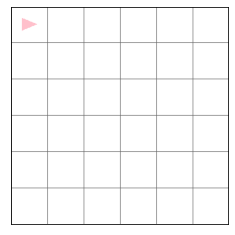

In [19]:
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['QT_QPA_PLATFORM']='offscreen'
world = World(grid_size=6, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world_rgb = world.render_simple()

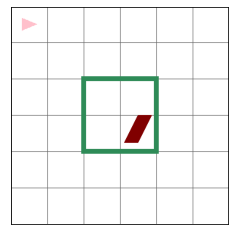

In [29]:
# try to place an object on to the map
world.clear_situation()
# world.place_object(Object(size=4, color="green", shape="box"), position=Position(row=3, column=3))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
world.place_object(Object(size=3, color="red", shape="cylinder"), position=Position(row=3, column=3))
_ = world.render_simple()